<a href="https://colab.research.google.com/github/xoelmv/Aprendizaje-Automatico/blob/main/Lab3_Parte_2(Redes_neuronales_usando_Keras).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eirasf/GCED-AA2/blob/main/lab3/lab3_parte2.ipynb)
# Práctica 2: Redes neuronales usando Keras
## Parte 2. El modelo Sequential


# Pre-requisitos

## Instalar paquetes

Para esta segunda parte también necesitaremos TensorFlow 2.0 y TensorFlow-Datasets

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

##Cargamos el conjunto de datos

De nuevo, seguimos empleando el conjunto *german_credit_numeric* ya empleado en el *Laboratorio 2* y en la primera parte de este Laboratorio.


In [24]:
tamano_lote = 1000

# Dividir el único split en entrenamiento (80%) y test (20%)
ds_train, ds_test = tfds.load(
    'german_credit_numeric',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True
)

# Agrupar en lotes
elems_train = ds_train.batch(tamano_lote)
elems_test  = ds_test.batch(tamano_lote)

# Primer lote de entrenamiento
lote_entrenamiento = next(iter(elems_train))

# Primer lote de test
lote_test = next(iter(elems_test))

# Comprobar tamaños
print("Entrenamiento X:", lote_entrenamiento[0].shape, "y:", lote_entrenamiento[1].shape)
print("Test X:", lote_test[0].shape, "y:", lote_test[1].shape)


Entrenamiento X: (800, 24) y: (800,)
Test X: (200, 24) y: (200,)


También vamos a establecer la función de pérdida y el algoritmo que vamos a emplear para el entrenamiento. Además, establecemos la métrica que nos servirá para evaluar el rendimiento del modelo entrenado, en este caso usaremos Precision (se pueden consultar más métricas aquí https://keras.io/api/metrics/)

In [41]:
# Función de pérdida
fn_perdida = tf.keras.losses.BinaryCrossentropy()

# Optimizador: SGD con tasa de aprendizaje 0.1
optimizador = tf.keras.optimizers.SGD(learning_rate=0.1)

# Métrica de evaluación: Precisión
metrica = tf.keras.metrics.Precision(name='Precision')


# Modelo *Sequential*

Un modelo *Sequential* nos permite concatenar una serie de capas, tal y como hemos visto en la parte 1, donde cada capa tiene exactamente un tensor de entrada y un tensor de salida.
Por otro lado, el modelo *Sequential* no es adecuado cuando:
- El modelo tiene múltiples entradas o múltiples salidas
- Cualquiera de las capas tiene múltiples entradas o múltiples salidas
- Necesitas compartir capas
- Se desea una topología no lineal

En Keras un modelo *Sequential* se define como:
$$model =  tf.keras.models.Sequential()$$
El constructor puede recibir como argumentos tanto el nombre que le queremos asignar al modelo, *name*, como la lista de capas que van a conformar el modelo.

Alternativamente, el método *add* nos permite ir añadiendo distintas capas al modelo. También existe un método, *pop*, que permite realizar la operación contraria, i.e, eliminar capas del modelo.

Para representar el mismo modelo que hemos realizado en la parte 1 de este laboratorio incluiremos 3 capas complentamente conectadas (*Dense*), indicando las unidades (*units*) que va a tener cada capa y su función de activación (*activation*). También se puede definir la *InputLayer* que se usa como punto de entrada a la red, indicando el número de entradas que tendrá el modelo.
Tras definir las capas, el modelo no está "construido", i.e., no tiene pesos.
Para ver si la estructura de nuestro modelo es correcta, podemos construirlo (*build*) e imprimir un resumen (*summary*) que nos mostrará en modo texto la siguiente información:
- Las capas y su orden en el modelo.
- La forma de salida de cada capa.
- El número de parámetros (pesos) en cada capa.
- El número total de parámetros (pesos) en el modelo.

In [42]:
tamano_entrada = 24
h0_size = 5
h1_size = 3
#TODO - define el modelo indicando un nombre
model =  tf.keras.models.Sequential(name="Model")

model.add( tf.keras.layers.InputLayer((tamano_entrada,)))
#TODO - incluye las 3 capas Dense al modelo
model.add(tf.keras.layers.Dense(h0_size, activation="sigmoid"))
model.add(tf.keras.layers.Dense(h1_size, activation="sigmoid"))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

#Se construye el modelo y se muestra
model.build()
print(model.summary())

Model: "Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 5)              │           125 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 3)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 147 (588.00 B)

 Trainable params: 147 (588.00 B)

 Non-trainable params: 0 (0.00 B)

None


Podemos trazar nuestro modelo como un gráfico

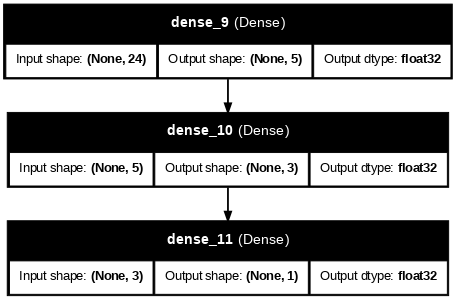

In [46]:
tf.keras.utils.plot_model(
    model,
    to_file='my_first_model.png',
    show_shapes=True,    # Muestra la forma de entrada y salida de cada capa
    show_dtype=True,     # Muestra el tipo de dato de cada tensor
    show_layer_names=True,
    expand_nested=False,
    dpi=65   # Disminuye el tamaño de la imagen (valor por defecto ~96)
)


Una vez que tenemos la arquitectura de nuestro modelo, podemos pasar a entrenarlo y evaluar su rendimiento.
Comenzamos configurar su entrenamiento tenemos el método *compile* que admite como argumentos:
1. la función de pérdida (*loss*)
1. el algoritmo de entrenamiento (*optimizer*)
1. la métrica para evaluar el rendimiento (*metrics*).

In [47]:
#TODO - indicar los parametros del método compile
model.compile(loss=fn_perdida,
              optimizer=optimizador,
              metrics=[metrica])

Después, solo falta llamar al método *fit* que entrenará el modelo dividiendo los datos en "batches" de tamaño *batch_size* e iterando repetidamente sobre todo el conjunto de datos para un número determinado de *epochs*. También es necesario indicarle los datos de entrada y la salida deseada. Podemos almacenar el resultado del modelo en un objeto, lo cual nos permitirá tener un registro de los valores de pérdida y las métricas durante el entrenamiento.

In [48]:
num_epochs =  50
#TODO - entrenar el modelo
history = model.fit(lote_entrenamiento[0], lote_entrenamiento[1], epochs=num_epochs, batch_size=500)
# lote_entrenamiento[0] -> x_train
# lote_entrenamiento[1] -> y_train

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - Precision: 0.7043 - loss: 0.6751 
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - Precision: 0.7103 - loss: 0.6636
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - Precision: 0.7023 - loss: 0.6570
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - Precision: 0.7003 - loss: 0.6504
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - Precision: 0.7090 - loss: 0.6413
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - Precision: 0.7050 - loss: 0.6378
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - Precision: 0.7163 - loss: 0.6286
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - Precision: 0.6977 - loss: 0.6329
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - Precision: 0.7123 - loss: 0.6232
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - Precision: 0.7070 - loss: 0.6226
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - Precision: 0.7030 - loss: 0.6223
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - Precision: 0.7030 - l

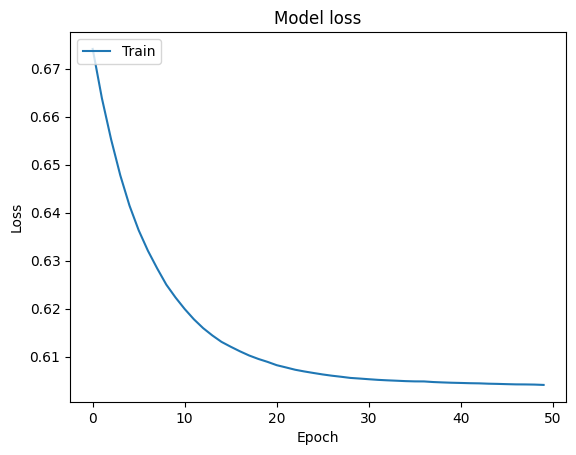

In [49]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Una vez el modelo está entrenado, podemos evaluarlo (método *evaluate*) con un nuevo conjunto de datos no usado durante el entrenamiento (el conjunto de *test*) para ver su rendimiento. En este caso, por simplicidad y a modo de ejemplo, evaluaremos sobre todo el conjunto.

In [50]:
#TODO - llamar a evaluate, guardando el resultado
result = model.evaluate(lote_test[0], lote_test[1])

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6501 - loss: 0.6562  


Por último, mostramos el resultado obtenido

In [51]:
print(model.metrics_names)
print(result)

['loss', 'compile_metrics']
[0.6377445459365845, 0.6700000166893005]
